In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from utils import draw_n_samples_real

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack([gradient] * 20)  # Make it tall enough to see

# Plot the gradient with the custom colormap
plt.figure(figsize = (8, 1))
plt.imshow(gradient, aspect = 'auto', cmap = "jet")
plt.axis('off')

plt.savefig(f"figures/cmaps/jet.png", dpi = 100, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
# 5 sims x 5 models = 25
# for sim_name, sim_func in simulations.items():
sim_name = "curve"

# Extract gt
y_test = y_test_dict[sim_name].detach().cpu()  # shape: (N_SIDE^2, 2)

X = x_test[:, 0].reshape(N_SIDE, N_SIDE).detach()
Y = x_test[:, 1].reshape(N_SIDE, N_SIDE).detach()

for model_name in ["GP", "dfGP", "dfNGP"]: # "dfNN",
    print(f"Processing {sim_name} with {model_name}...") 
    mean_path = "results_sim/" + model_name + "/" + sim_name + "_" + model_name + "_test_mean_predictions.pt"
    covar_path = "results_sim/" + model_name + "/" + sim_name + "_" + model_name + "_test_covar_predictions.pt"

    mean = torch.load(mean_path, weights_only = False).detach().cpu()
    covar = torch.load(covar_path, weights_only = False).detach().cpu()

    # covar_interleave = reshape_covar_block_to_interleaved(covar)

    n_samples = 3
    n_sample_tensor = draw_n_samples_block_input(mean, covar, n_samples, max_jitter = 1e-1)

    ### Uncertainty ###
    var = torch.diag(covar)[:(N_SIDE * N_SIDE)].reshape(N_SIDE, N_SIDE) + torch.diag(covar)[(N_SIDE * N_SIDE):].reshape(N_SIDE, N_SIDE)

    n_sample_tensor_speed = torch.sqrt(n_sample_tensor[:, :, :, 0]**2 + n_sample_tensor[:, :, :, 1]**2) 

    ### Samples ###
    for i in range(n_samples):
        sample = n_sample_tensor[i]

        sample_speed = n_sample_tensor_speed[i]

        U = sample[:, :, 0]
        V = sample[:, :, 1]

        plt.figure(figsize = (5, 5))

        ### Plot samples ###

        # background color
        # plt.pcolor(X, Y, sample_speed.detach().numpy(), cmap = "jet", vmin = 0, vmax = 3.0, alpha = 0.5)

        quiver_scale = standard_quiver_scale
        if sim_name == "branching":
            quiver_scale = branching_quiver_scale
        plt.quiver(X, Y, U, V, sample_speed, scale = quiver_scale, cmap = "jet", clim = (0.0, 3.0), 
                   linewidth = 0.08, width = 0.005, edgecolor = "gray") # fixed scale for consistency # width makes it fat

        plt.gca().set_aspect('equal')
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])

        plt.savefig(f"figures/samples_speedcolor/{sim_name}_{model_name}_sample_{i}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

        if show_bool:
            plt.show()
        plt.close()

# Plot prediction

In [ ]:
for region_name in ["region_lower_byrd", "region_mid_byrd", "region_upper_byrd"]:

    print(f"\nTraining for {region_name.upper()}...")

    # Store metrics for the current simulation
    region_results = []

    #########################
    ### x_train & y_train ###
    #########################

    path_to_training_tensor = "data/real_data/" + region_name + "_train_tensor.pt"
    path_to_test_tensor = "data/real_data/" + region_name + "_test_tensor.pt"

    train = torch.load(path_to_training_tensor).T # we need to transpose the tensor to have observations in the first dimension
    test = torch.load(path_to_test_tensor).T

    # The train and test tensors have the following columns:
    # [:, 0] = x
    # [:, 1] = y
    # [:, 2] = surface elevation (s)
    # [:, 3] = ice flux in x direction (u)
    # [:, 4] = ice flux in y direction (v)
    # [:, 5] = ice flux error in x direction (u_err)
    # [:, 6] = ice flux error in y direction (v_err)

    x_train = train[:, [0, 1]].to(device).cpu()
    y_train = train[:, [3, 4]].to(device).cpu()

    x_test = test[:, [0, 1]].to(device).cpu()
    y_test = test[:, [3, 4]].to(device).cpu()

    for model_name in ["PINN", "dfNN", "GP", "dfGP", "dfNGP"]:
        print(f"\n{model_name.upper()}")

        if model_name in ["dfGP", "GP", "dfNGP"]:
            path_to_y_test_prediction = "results_real/" + model_name + "/" + region_name + "_" + model_name + "_test_mean_predictions.pt"
        else:
            path_to_y_test_prediction = "results_real/" + model_name + "/" + region_name + "_" + model_name + "_test_predictions.pt"

        y_test_prediction = torch.load(path_to_y_test_prediction).to(device).detach().cpu()

        fig, ax = plt.subplots(1, 1, figsize = (5, 5))
    
        # Plot ground truth test data in black
        ax.quiver(x_test[:, 0], x_test[:, 1], y_test_prediction[:, 0], y_test_prediction[:, 1], color = "black")

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        # Remove axis labels
        ax.set_xticks([])
        ax.set_yticks([])
            
        ax.set_aspect("equal")

        plt.show()

# Plot prediction and gt

In [ ]:
for region_name in ["region_lower_byrd", "region_mid_byrd", "region_upper_byrd"]:

    print(f"\nTraining for {region_name.upper()}...")

    # Store metrics for the current simulation
    region_results = []

    #########################
    ### x_train & y_train ###
    #########################

    path_to_training_tensor = "data/real_data/" + region_name + "_train_tensor.pt"
    path_to_test_tensor = "data/real_data/" + region_name + "_test_tensor.pt"

    train = torch.load(path_to_training_tensor, weights_only = False).T # we need to transpose the tensor to have observations in the first dimension
    test = torch.load(path_to_test_tensor, weights_only = False).T

    # The train and test tensors have the following columns:
    # [:, 0] = x
    # [:, 1] = y
    # [:, 2] = surface elevation (s)
    # [:, 3] = ice flux in x direction (u)
    # [:, 4] = ice flux in y direction (v)
    # [:, 5] = ice flux error in x direction (u_err)
    # [:, 6] = ice flux error in y direction (v_err)

    x_train = train[:, [0, 1]].to(device).cpu()
    y_train = train[:, [3, 4]].to(device).cpu()

    x_test = test[:, [0, 1]].to(device).cpu()
    y_test = test[:, [3, 4]].to(device).cpu()

    for model_name in ["PINN", "dfNN", "GP", "dfGP", "dfNGP"]:
        print(f"\n{model_name.upper()}")

        if model_name in ["dfGP", "GP", "dfNGP"]:
            path_to_y_test_prediction = "results_real/" + model_name + "/" + region_name + "_" + model_name + "_test_mean_predictions.pt"
        else:
            path_to_y_test_prediction = "results_real/" + model_name + "/" + region_name + "_" + model_name + "_test_predictions.pt"

        y_test_prediction = torch.load(path_to_y_test_prediction, weights_only = False).to(device).detach().cpu()

        fig, axes = plt.subplots(1, 2, figsize = (10, 5))

        # --- Plot Ground Truth on the left ---
        axes[0].quiver(x_test[:, 0], x_test[:, 1], y_test[:, 0], y_test[:, 1], color = "black")
        axes[0].quiver(x_train[:, 0], x_train[:, 1], y_train[:, 0], y_train[:, 1], color = "brown", alpha = 0.5)
        axes[0].set_title("Ground Truth")
        axes[0].set_xlim(0, 1)
        axes[0].set_ylim(0, 1)
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        axes[0].set_aspect("equal")

        # --- Plot Prediction on the right ---
        axes[1].quiver(x_test[:, 0], x_test[:, 1], y_test_prediction[:, 0], y_test_prediction[:, 1], color = "blue")
        axes[1].set_title("Prediction")
        axes[1].set_xlim(0, 1)
        axes[1].set_ylim(0, 1)
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        axes[1].set_aspect("equal")

        plt.tight_layout()
        plt.show()

# Samples

Jitter: 9.999999999999999e-06


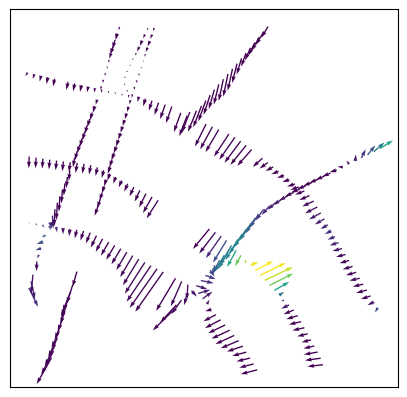

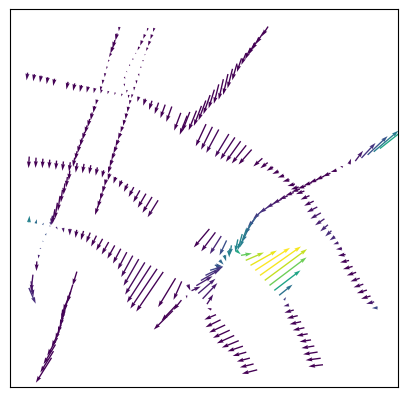

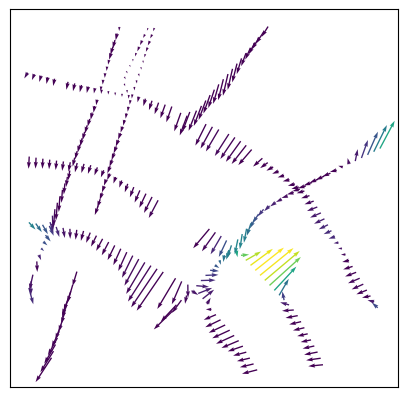

Jitter: 9.999999999999999e-06


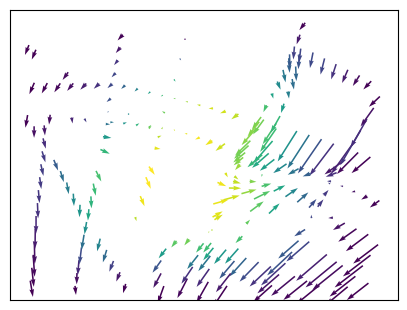

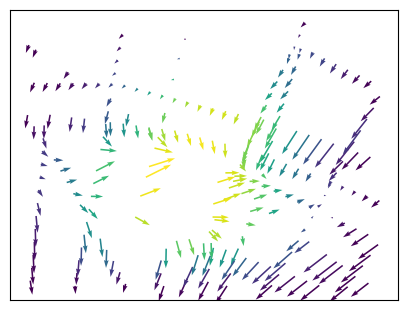

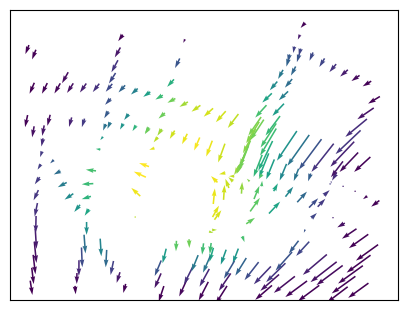

Jitter: 9.999999999999999e-06


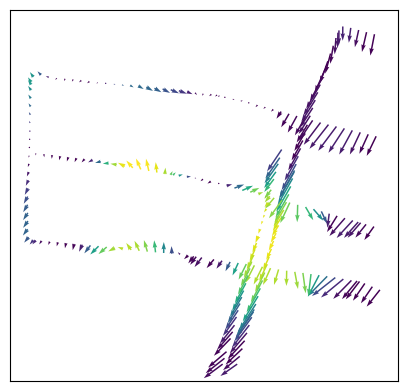

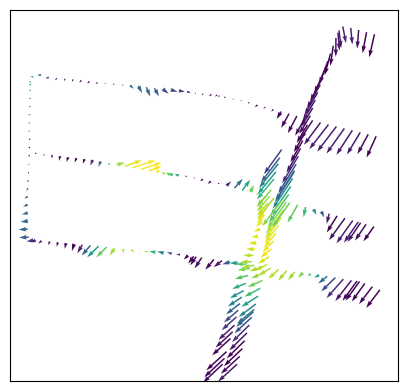

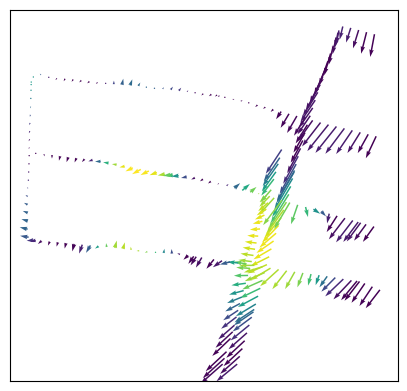

In [10]:
show_bool = True
# 5 sims x 5 models = 25
for region_name in ["region_lower_byrd", "region_mid_byrd", "region_upper_byrd"]:

    path_to_training_tensor = "data/real_data/" + region_name + "_train_tensor.pt"
    path_to_test_tensor = "data/real_data/" + region_name + "_test_tensor.pt"

    train = torch.load(path_to_training_tensor, weights_only = False).T # we need to transpose the tensor to have observations in the first dimension
    test = torch.load(path_to_test_tensor, weights_only = False).T

    # The train and test tensors have the following columns:
    # [:, 0] = x
    # [:, 1] = y
    # [:, 2] = surface elevation (s)
    # [:, 3] = ice flux in x direction (u)
    # [:, 4] = ice flux in y direction (v)
    # [:, 5] = ice flux error in x direction (u_err)
    # [:, 6] = ice flux error in y direction (v_err)

    x_train = train[:, [0, 1]].to(device).cpu()
    y_train = train[:, [3, 4]].to(device).cpu()

    x_test = test[:, [0, 1]].to(device).cpu()
    y_test = test[:, [3, 4]].to(device).cpu()

    N_test = x_test.shape[0]

    for model_name in ["GP"]: # "GP", "dfGP", "dfNGP"

        mean_path = "results_real/" + model_name + "/" + region_name + "_" + model_name + "_test_mean_predictions.pt"
        covar_path = "results_real/" + model_name + "/" + region_name + "_" + model_name + "_test_covar_predictions.pt"

        mean = torch.load(mean_path, weights_only = False).detach().cpu()
        covar = torch.load(covar_path, weights_only = False).detach().cpu()

        n_samples = 3
        n_sample_tensor = draw_n_samples_real(mean, covar, n_samples = 3)

        ### Uncertainty ###
        var = torch.diag(covar)[:N_test] + torch.diag(covar)[N_test:]

        ### Samples ###
        for i in range(n_samples):
            sample = n_sample_tensor[i]

            U = sample[:, 0]
            V = sample[:, 1]

            plt.figure(figsize = (5, 5))

            ### Plot samples ###
            # quiver_scale = standard_quiver_scale
            plt.quiver(x_test[:, 0], x_test[:, 1], U, V, var) # fixed scale for consistency

            plt.gca().set_aspect('equal')
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])

            # plt.savefig(f"figures/samples/{sim_name}_{model_name}_sample_{i}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

            if show_bool:
                plt.show()
            plt.close()

In [11]:
torch.sqrt(var).mean()

tensor(0.8861)

# Error


PINN


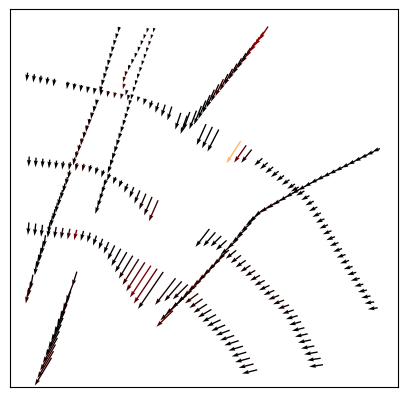


DFNN


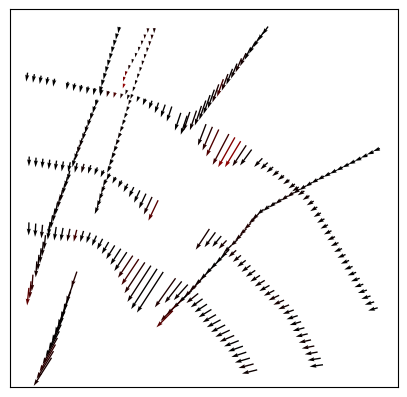


GP


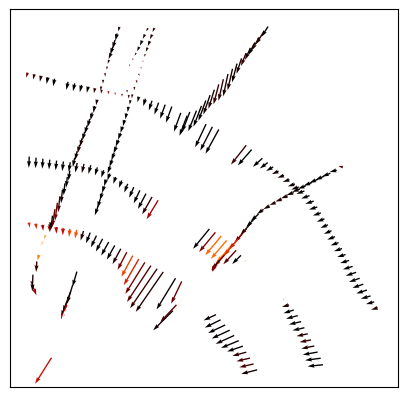


DFGP


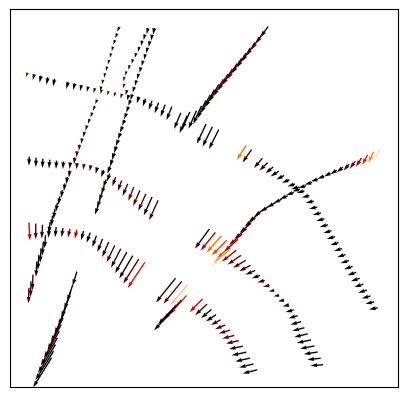


DFNGP


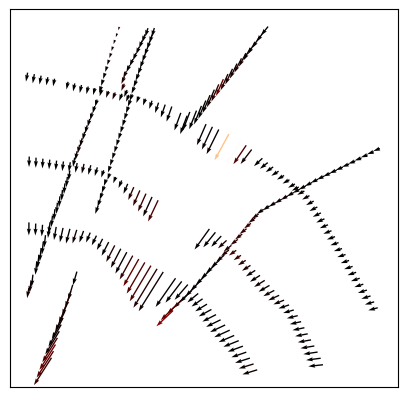


PINN


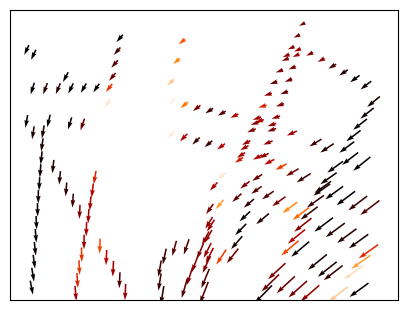


DFNN


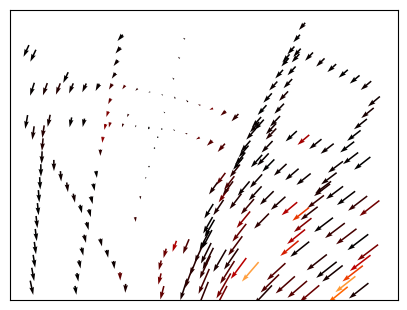


GP


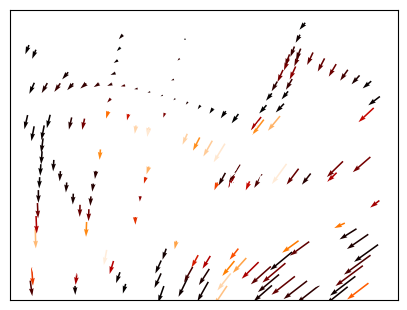


DFGP


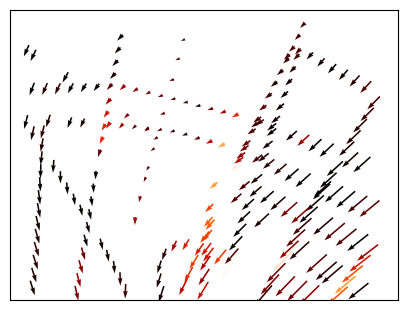


DFNGP


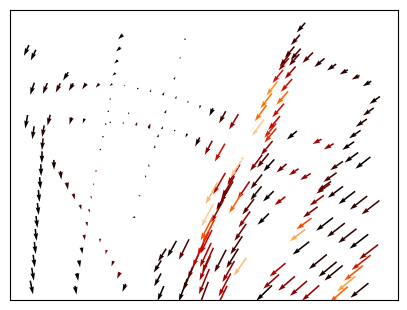


PINN


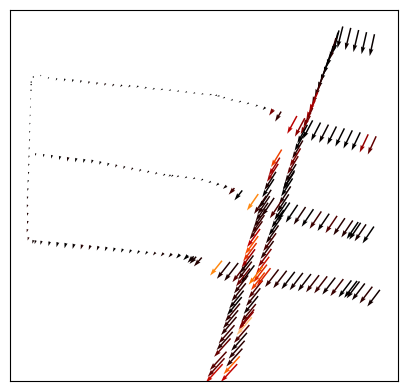


DFNN


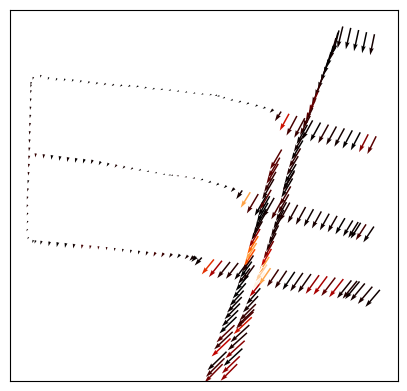


GP


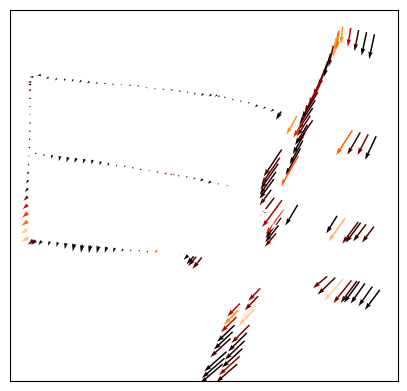


DFGP


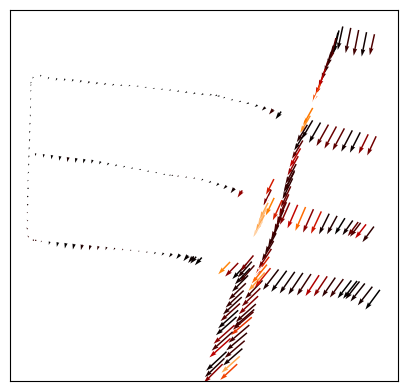


DFNGP


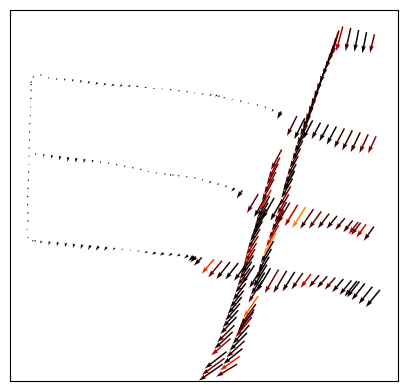

In [21]:
show_bool = True

for region_name in ["region_lower_byrd", "region_mid_byrd", "region_upper_byrd"]:

    path_to_training_tensor = "data/real_data/" + region_name + "_train_tensor.pt"
    path_to_test_tensor = "data/real_data/" + region_name + "_test_tensor.pt"

    train = torch.load(path_to_training_tensor, weights_only = False).T # we need to transpose the tensor to have observations in the first dimension
    test = torch.load(path_to_test_tensor, weights_only = False).T

    # The train and test tensors have the following columns:
    # [:, 0] = x
    # [:, 1] = y
    # [:, 2] = surface elevation (s)
    # [:, 3] = ice flux in x direction (u)
    # [:, 4] = ice flux in y direction (v)
    # [:, 5] = ice flux error in x direction (u_err)
    # [:, 6] = ice flux error in y direction (v_err)

    x_train = train[:, [0, 1]].to(device).cpu()
    y_train = train[:, [3, 4]].to(device).cpu()

    x_test = test[:, [0, 1]].to(device).cpu()
    y_test = test[:, [3, 4]].to(device).cpu()

    N_test = x_test.shape[0]

    for model_name in ["PINN", "dfNN", "GP", "dfGP", "dfNGP"]: # "GP", "dfGP", "dfNGP"
        print(f"\n{model_name.upper()}")
        if model_name in ["GP", "dfGP", "dfNGP"]: # "GP", "dfGP", "dfNGP"
            mean_path = "results_real/" + model_name + "/" + region_name + "_" + model_name + "_test_mean_predictions.pt"
        else:
            mean_path = "results_real/" + model_name + "/" + region_name + "_" + model_name + "_test_predictions.pt"

        mean = torch.load(mean_path, weights_only = False).detach().cpu()

        U = mean[:, 0]
        V = mean[:, 1]

        error = torch.mean(torch.square(mean - y_test), dim = -1)

        plt.figure(figsize = (5, 5))

        ### Plot samples ###
        plt.quiver(x_test[:, 0], x_test[:, 1], U, V, error, cmap = "gist_heat", clim = (0.0, 1.0)) # fixed scale for consistency

        plt.gca().set_aspect('equal')
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])

        # plt.savefig(f"figures/samples/{sim_name}_{model_name}_sample_{i}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

        if show_bool:
            plt.show()
        plt.close()